In [89]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import tqdm
import joblib
import copy
import random
import os
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import extract_features, EfficientFCParameters, MinimalFCParameters

from xgboost.sklearn import XGBRegressor
import xgboost as xgb

xgb.set_config(verbosity=0)

import torch
import torch.nn as nn
import torch.nn.functional as F

plt.rcParams['font.sans-serif'] = ['SimHei']


class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


class TransAm(nn.Module):
    def __init__(self, feature_size=1325, dropout=0.1):
        super(TransAm, self).__init__()
        self.decoder = nn.Linear(feature_size, feature_size)
        # self.decoder = FeedForward(feature_size,4*feature_size,dropout)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        output = self.decoder(x)
        return output


def get_batch(source, label, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    input = source[i:i + seq_len]
    target = label[i:i + seq_len]
    return input, target


In [90]:
def xgboot_reg(data, target):
    # 切分训练集和测试集
    data = torch.FloatTensor(data.to_numpy())
    target = torch.FloatTensor(target.to_numpy())
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.3,
                                                        random_state=random.randint(1, 10000))

    model = TransAm()
    criterion = nn.MSELoss()
    lr = 0.01
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

    model.train()  # Turn on the train mode
    epochs = 20
    batch_size = 128

    global bst
    for epoch in range(epochs):
        for batch, i in enumerate(range(0, len(train_x) - 1, batch_size)):
            data, targets = get_batch(train_x, train_y, i, batch_size)
            optimizer.zero_grad()
            output = model(data).detach().numpy()
            data = output
            # 建模与预测：50棵树
            eval_set = [(test_x, test_y)]
            if epoch:
                bst.load_model('./model.json')
                bst = xgb.XGBRegressor(max_depth=6,learning_rate=0.05,n_estimators=100,randam_state=42)
                bst.fit(data, targets)
                bst.save_model('./model.json')
            else:
                bst = xgb.XGBRegressor(max_depth=6,learning_rate=0.05,n_estimators=100,randam_state=42)
                bst.fit(data, targets)
                if os.path.exists('./model.json'):
                    os.remove('./model.json')
                bst.save_model('./model.json')
            ypred = torch.Tensor(bst.predict(data))
            loss = criterion(ypred, targets)
            # print('loss:{}'.format(loss))
            loss.requires_grad_(True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            scheduler.step()

    model.eval()  # Turn on the evaluation mode
    with torch.no_grad():
        output = model(test_x).detach().numpy()
        ypred = bst.predict(output)
        msetest = mean_squared_error(ypred, test_y)
        print(msetest)
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8), dpi=100)
        # pred
        a = pd.Series(np.array(ypred))
        a.plot(ax=axes, legend=True, color='blue',label='pred')
        a1 = a.pct_change().fillna(method='ffill')
        a1 = list(a1.apply(lambda x: True if x>0 else False))
        # real
        b = pd.Series(np.array(test_y))
        b.plot(ax=axes, legend=True, color='red',label='real')
        b1 = b.pct_change().fillna(method='ffill')
        b1 = list(b1.apply(lambda x: True if x>0 else False))
        c = [True if a1[i]==b1[i] else False for i in range(len(a1))]
        print('预测准确率：{}'.format(c.count(True)/len(c)))


In [91]:
if __name__ == "__main__":
    print('data processing...')
    settings = EfficientFCParameters()
    df = pd.read_csv('./data1.csv', index_col=['bob'])
    df.drop(columns=['id', 'position', 'eob', 'frequency'], inplace=True)
    df['time'] = df.index

    # 滚动处理时间序列，指定id列和时间列，滚动处理时序数据
    df_rolled = roll_time_series(df, column_id="symbol", column_sort="time",
                                 max_timeshift=20, min_timeshift=5)

    df_rolled.drop(columns=['symbol'], inplace=True)  # 删除name列, inplace为直接修改df，否则需要赋值给新的变量

    X = extract_features(df_rolled, column_id="id", column_sort="time",
                         default_fc_parameters=settings)
    impute(X)

    X = X.set_index([X.index.map(lambda x: x[0]), X.index.map(lambda x: x[1])], drop=False)
    X.index.names = ["Symbols", "last_date"]

    y = df.groupby("symbol").apply(lambda x: x.set_index("time")["close"].shift(-1)).T.unstack().fillna(method='ffill')

    y = y[y.index.isin(X.index)]
    X = X[X.index.isin(y.index)]

    features_filtered_0 = select_features(X, y)
    # y = df.groupby("symbol").apply(
    #     lambda x: x.set_index("time")["close"].shift(-1).pct_change().fillna(0)).T.unstack().fillna(method='ffill')
    # y = y.apply(lambda x: True if x > 0 else False)[y.index.isin(features_filtered_0.index)]

    y = df.groupby("symbol").apply(
        lambda x: x.set_index("time")["close"].shift(-1).pct_change().fillna(0)).T.unstack().fillna(method='ffill')
    y = y[y.index.isin(features_filtered_0.index)]



data processing...


Feature Extraction: 100%|██████████| 30/30 [01:23<00:00,  2.79s/it]
C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\tsfresh\utilities\dataframe_functions.py:172: RuntimeWarning:

The columns ['open__fft_coefficient__attr_"real"__coeff_11'
 'open__fft_coefficient__attr_"real"__coeff_12'
 'open__fft_coefficient__attr_"real"__coeff_13' ...
 'pre_close__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'pre_close__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'pre_close__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.



0.00049301225
预测准确率：0.6194968553459119


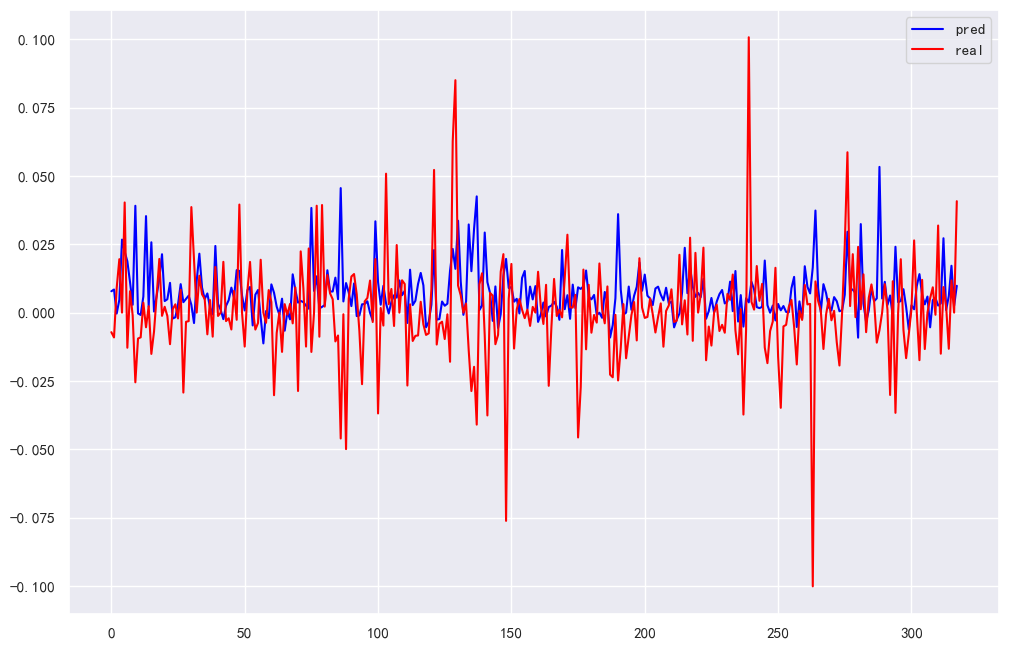

In [94]:
xgboot_reg(features_filtered_0, y)

